## Importing relevant Libraries

In [73]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [74]:
%cd /gdrive/My Drive/Text Summarizer

/gdrive/My Drive/Text Summarizer


In [75]:
!pwd

/gdrive/My Drive/Text Summarizer


In [76]:
from attention import AttentionLayer

In [77]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
pd.set_option('display.max_colwidth',200)
import warnings
warnings.filterwarnings('ignore')

## Reading Data
Then data has been taken from Kaggle:-
https://www.kaggle.com/snap/amazon-fine-food-reviews/notebooks

In [78]:
data=pd.read_csv('Reviews.csv',nrows=100000)

In [79]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [80]:
for i in range(10):
    print(data['Text'][i])
    print('\n')

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.


If you are looking for the se

# PREPROCESSING
We will drop unwanted symbols,characters,etc. from the data so that they don't affect our objective.

In [81]:
from contraction import contraction_mapping

**We will use the following dictionary for expanding the contractions present in the comments.**

In [82]:
contraction_mapping

{"'cause": 'because',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "could've": 'could have',
 "couldn't": 'could not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'll": 'he will',
 "he's": 'he is',
 "here's": 'here is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must

## a.) Text Cleaning

In [83]:
import nltk
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
def text_cleaner(text):
    new_str=text.lower()
    new_str=BeautifulSoup(new_str,'lxml').text
    new_str=re.sub(r'\([^)]*\)', '', new_str)
    new_str=re.sub('"','', new_str)
    new_str=' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_str.split(' ')])
    new_str=re.sub(r"'s\b","",new_str)
    new_str=re.sub("[^a-zA-Z]", " ", new_str) 
    tokens=[w for w in new_str.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)
    return (" ".join(long_words)).strip()



In [85]:
data['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [86]:
text_cleaner(data['Text'][0])

'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [87]:
cleaned_text=[]
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

## b.) Summary Cleaning

In [88]:
for i in range(10):
    print(data['Summary'][i])
    print('\n')

Good Quality Dog Food


Not as Advertised


"Delight" says it all


Cough Medicine


Great taffy


Nice Taffy


Great!  Just as good as the expensive brands!


Wonderful, tasty taffy


Yay Barley


Healthy Dog Food




In [89]:
def summary_cleaner(text):
    newString = re.sub('"','', str(text))
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [90]:
cleaned_summary=[]

for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [91]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('',np.nan,inplace=True)
data.dropna(axis=0,inplace=True)

**We also have to pad the summary with _START_ and _END_ tags.**</br>
We will use **TRATO** as the start tag and **DNES** as the end tag.
We should keep in mind that these start and end tags should not be commonly used words.

In [92]:
data['cleaned_summary']=data['cleaned_summary'].apply(lambda x:'TRATO ' + x + 'DNES')

In [93]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: TRATO good quality dog food DNES


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: TRATO not as advertised DNES


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: TRATO delight says it all DNES


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: TRATO cough medicine DNES


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary

# Data Analysis

In [94]:
import matplotlib.pyplot as plt
text_word_count=[]
summary_word_count=[]

for i in data['cleaned_text']:
    text_word_count.append(len(i.split()))
    
for j in data['cleaned_summary']:
    summary_word_count.append(len(j.split()))    
    
length_df=pd.DataFrame({'text':text_word_count,'summary':summary_word_count})
length_df

,text,summary
0,23,6
1,18,5
2,39,6
3,17,4
4,13,4
...,...,...
99909,7,3
99910,91,5
99911,20,4
99912,28,3


In [95]:
length_df.describe([0.1,0.2,0.9,0.95,0.99]).T

,count,mean,std,min,10%,20%,50%,90%,95%,99%,max
text,99914.0,38.374692,36.825957,2.0,12.0,15.0,27.0,76.0,103.0,182.0,1212.0
summary,99914.0,6.012621,2.487182,3.0,3.0,4.0,5.0,9.0,11.0,14.0,29.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f235ced0da0>,
      dtype=object)

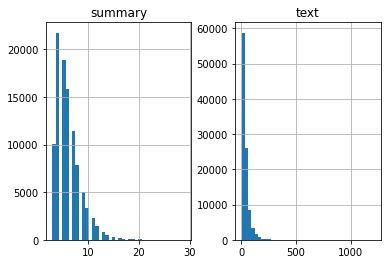

In [96]:
length_df.hist(bins=40)

**Let us set the maximum length for text and summaries.**

In [97]:
max_len_text=80 
max_len_summary=10

### Let's split the data

In [98]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 


# Preparing the tokenizer

## a.) Text Tokenixer

In [99]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))


x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)


x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [100]:
x_tokenizer.word_index

{'like': 1,
 'good': 2,
 'taste': 3,
 'one': 4,
 'great': 5,
 'would': 6,
 'product': 7,
 'flavor': 8,
 'coffee': 9,
 'tea': 10,
 'love': 11,
 'food': 12,
 'get': 13,
 'really': 14,
 'much': 15,
 'amazon': 16,
 'also': 17,
 'time': 18,
 'little': 19,
 'dog': 20,
 'use': 21,
 'buy': 22,
 'price': 23,
 'best': 24,
 'tried': 25,
 'make': 26,
 'well': 27,
 'find': 28,
 'even': 29,
 'better': 30,
 'try': 31,
 'chocolate': 32,
 'eat': 33,
 'first': 34,
 'bag': 35,
 'could': 36,
 'drink': 37,
 'sugar': 38,
 'cup': 39,
 'found': 40,
 'sweet': 41,
 'water': 42,
 'used': 43,
 'made': 44,
 'think': 45,
 'bought': 46,
 'box': 47,
 'way': 48,
 'two': 49,
 'cannot': 50,
 'day': 51,
 'since': 52,
 'bit': 53,
 'free': 54,
 'give': 55,
 'tastes': 56,
 'dogs': 57,
 'still': 58,
 'store': 59,
 'order': 60,
 'chips': 61,
 'recommend': 62,
 'know': 63,
 'nice': 64,
 'delicious': 65,
 'got': 66,
 'flavors': 67,
 'many': 68,
 'favorite': 69,
 'mix': 70,
 'treats': 71,
 'something': 72,
 'want': 73,
 'never':

## b.) Summary Tokenizer

In [101]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))


y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 


y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [102]:
y_tokenizer.word_index #shows the most common words first

{'trato': 1,
 'dnes': 2,
 'great': 3,
 'the': 4,
 'good': 5,
 'not': 6,
 'for': 7,
 'and': 8,
 'it': 9,
 'best': 10,
 'my': 11,
 'love': 12,
 'but': 13,
 'this': 14,
 'tea': 15,
 'to': 16,
 'is': 17,
 'coffee': 18,
 'of': 19,
 'product': 20,
 'delicious': 21,
 'taste': 22,
 'very': 23,
 'dog': 24,
 'in': 25,
 'flavor': 26,
 'like': 27,
 'these': 28,
 'excellent': 29,
 'food': 30,
 'tasty': 31,
 'you': 32,
 'price': 33,
 'yummy': 34,
 'too': 35,
 'with': 36,
 'favorite': 37,
 'as': 38,
 'ever': 39,
 'are': 40,
 'so': 41,
 'dogs': 42,
 'loves': 43,
 'on': 44,
 'snack': 45,
 'stuff': 46,
 'have': 47,
 'better': 48,
 'just': 49,
 'healthy': 50,
 'no': 51,
 'them': 52,
 'chocolate': 53,
 'awesome': 54,
 'than': 55,
 'what': 56,
 'chips': 57,
 'tastes': 58,
 'perfect': 59,
 'free': 60,
 'sweet': 61,
 'nice': 62,
 'treat': 63,
 'yum': 64,
 'one': 65,
 'at': 66,
 'all': 67,
 'really': 68,
 'bad': 69,
 'quality': 70,
 'cat': 71,
 'your': 72,
 'me': 73,
 'tasting': 74,
 'wonderful': 75,
 'treats

# Model Building

In [103]:
from keras import backend as K
K.clear_session()
latent_dim=500

#Encoder
encoder_inputs=Input(shape=(max_len_text,))
enc_emb=Embedding(x_voc_size,latent_dim,trainable=True)(encoder_inputs)

#LSTM-1
encoder_lstm1=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1,state_h1,state_c1 = encoder_lstm1(enc_emb)

#LSTM-2
encoder_lstm2=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2,state_h2,state_c2 = encoder_lstm2(encoder_output1)

#LSTM-3
encoder_lstm3=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs,state_h,state_c = encoder_lstm3(encoder_output2)


#Decoder
decoder_inputs=Input(shape=(None,))
dec_emb_layer=Embedding(y_voc_size,latent_dim,trainable=True)
dec_emb=dec_emb_layer(decoder_inputs)

decoder_lstm=LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs,decoder_fwd_state,decoder_back_state=decoder_lstm(dec_emb,initial_state=[state_h,state_c])

#Attention Layer
attn_layer=AttentionLayer(name='attention_layer')
attn_out,attn_states=attn_layer([encoder_outputs,decoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      25986000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [104]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [105]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [106]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/50
176/176 [==============================] - 109s 620ms/step - loss: 3.1557 - val_loss: 2.7812
Epoch 2/50
176/176 [==============================] - 108s 612ms/step - loss: 2.6676 - val_loss: 2.4898
Epoch 3/50
176/176 [==============================] - 108s 611ms/step - loss: 2.4142 - val_loss: 2.3173
Epoch 4/50
176/176 [==============================] - 107s 608ms/step - loss: 2.2441 - val_loss: 2.2234
Epoch 5/50
176/176 [==============================] - 107s 608ms/step - loss: 2.1131 - val_loss: 2.1632
Epoch 6/50
176/176 [==============================] - 107s 608ms/step - loss: 1.9981 - val_loss: 2.1248
Epoch 7/50
176/176 [==============================] - 107s 608ms/step - loss: 1.8917 - val_loss: 2.0918
Epoch 8/50
176/176 [==============================] - 107s 610ms/step - loss: 1.7896 - val_loss: 2.0679
Epoch 9/50
176/176 [==============================] - 107s 607ms/step - loss: 1.6918 - val_loss: 2.0569
Epoch 10/50
176/176 [==============================] - 107s 609m

**Diagnostic Plot** 

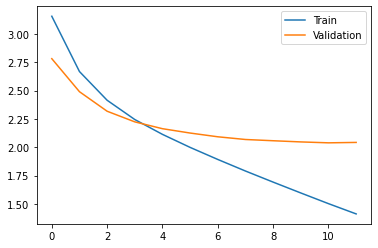

In [107]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()

**Dictionary to convert the index to word and source vocabulary**

In [108]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

# Inference Model

In [109]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

#  embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)


decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob 
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])



In [110]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    
    target_seq = np.zeros((1,1))
    
    
    target_seq[0, 0] = target_word_index['trato']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='dnes'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'dnes'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [111]:
def seq2summary(input_seq):
  new_str=''
  for i in input_seq:
    if((i!=0 and i!=target_word_index['trato']) and i!=target_word_index['dnes']):
      new_str=new_str + reverse_target_word_index[i]+' '
  return new_str

In [112]:
def seq2text(input_seq):
  new_str=''
  for i in input_seq:
    if(i!=0):
      new_str=new_str + reverse_source_word_index[i]+' '
  return new_str

In [113]:
for i in range(50):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: dogs loves chips meal vet always amazed good thier teeth look tater build 
Original summary: green cow rawhide chips 
Predicted summary:  my dog loves them


Review: dogs loves soft stinky treats great training small enough give lot concerned giving dog much food also healthy ingredients one treats sensetive gsd 
Original summary: great training treat 
Predicted summary:  great treats for training


Review: hot ginger tea sometimes served cold winter days restaurant know honey adds nice complexity cup also looking forward adding cloves cinnamon stick many uses crystals come mind well simply dissolving water using sugar tea black green definitely try another reviewer recommendation strawberries fruit complaint wish packet somewhat less sugar one packet getting bit close typical desert levels aside prefer ginger tea getting local korean market kind marmalade jelly ginger slices jar product stronger hotter ginger flavor used place granulated sugar 
Original summary: nice strong gi

In [114]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [115]:
!pwd

/gdrive/My Drive/Text Summarizer


# Testing Custom Inputs

In [116]:
text='The food delivery system is horrible. The food was delivered late and the delivery started to argue after i complained'
print(text)

The food delivery system is horrible. The food was delivered late and the delivery started to argue after i complained


In [117]:
cleaned_text=text_cleaner(text)
cleaned_text

'food delivery system horrible food delivered late delivery started argue complained'

In [118]:
text_tr=x_tokenizer.texts_to_sequences([cleaned_text])
text_padd= pad_sequences(text_tr,  maxlen=max_len_text, padding='post')

In [119]:
text_padd.shape

(1, 80)

In [120]:
print("Predicted summary:",decode_sequence(text_padd.reshape(1,max_len_text)))

Predicted summary:  not the best
